In [1]:
!git clone https://github.com/Zymrael/torchSODE.git

fatal: destination path 'torchSODE' already exists and is not an empty directory.


In [2]:
!cd torchSODE/ && git pull && git checkout new_branch
!cd ./torchSODE/src/ && python3 setup.py install

remote: Enumerating objects: 8, done.
remote: Counting objects: 100% (8/8), done.
remote: Compressing objects: 100% (8/8), done.
remote: Total 8 (delta 3), reused 2 (delta 0), pack-reused 0
Unpacking objects: 100% (8/8), done.
From https://github.com/Zymrael/torchSODE
   13c78c8..80af060  new_branch -> origin/new_branch
Updating 13c78c8..80af060
Fast-forward
 src/solver.cu | 2 +-
 1 file changed, 1 insertion(+), 1 deletion(-)
Already on 'new_branch'
Your branch is up to date with 'origin/new_branch'.
running install
running bdist_egg
running egg_info
writing torchSODE.egg-info/PKG-INFO
writing dependency_links to torchSODE.egg-info/dependency_links.txt
writing top-level names to torchSODE.egg-info/top_level.txt
writing manifest file 'torchSODE.egg-info/SOURCES.txt'
installing library code to build/bdist.linux-x86_64/egg
running install_lib
running build_ext
building 'torchSODE' extension
x86_64-linux-gnu-gcc -pthread -DNDEBUG -g -fwrapv -O2 -Wall -g -fstack-protector-strong -Wformat -W

In [3]:
!git clone https://github.com/rtqichen/torchdiffeq
!cd torchdiffeq && pip install -e .

Cloning into 'torchdiffeq'...
remote: Enumerating objects: 138, done.
remote: Total 138 (delta 0), reused 0 (delta 0), pack-reused 138
Receiving objects: 100% (138/138), 688.35 KiB | 1.75 MiB/s, done.
Resolving deltas: 100% (55/55), done.
Obtaining file:///content/torchdiffeq
  Running setup.py develop for torchdiffeq


In [4]:
!pip install ipyexperiments

In [0]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import scipy.integrate
import torchSODE
import torchdiffeq

In [0]:
import ipyexperiments
import timeit
import time

In [0]:
torch.cuda.manual_seed_all(2)

## Defining linear ODE model

Utility functions for testing purposes

In [0]:
class GenericModel(object):
    def __init__(self, F, numpy=True):
        if numpy: self.F = F.numpy()
        else: self.F = F
        self.numpy = numpy
    def __call__(self, dt, x):
        if self.numpy: return np.matmul(self.F, x)
        else: return torch.matmul(self.F, x)

In [0]:
class SparseModel(GenericModel):
    def __init__(self, F, numpy=True):
        super().__init__(F, numpy)
    def __call__(self, dt, x):
        return self.F[0][0]*x

In [0]:
class SparseBlockModel(object):
    def __init__(self, F, numpy=True):
        if numpy: F = F.numpy()
        self.p = [F[0][0], F[0][1], F[1][0], F[1][1]]
    def __call__(self, dt, x):
        x[:len(x)//2] = self.p[0] * x0[:len(x)//2] + self.p[1] * x0[len(x)//2:]
        x[len(x)//2:] = self.p[2] * x0[:len(x)//2] + self.p[3] * x0[len(x)//2:]
        return x

In [0]:
def generateFS(size, UL, UR, LL, LR):
  n = size//2
  ul = UL*torch.eye(n)
  ur = UR*torch.eye(n) 
  ll = LL*torch.eye(n)
  lr = LR*torch.eye(n)
  top = torch.cat((ul, ur),1)
  bottom = torch.cat((ll, lr),1)
  return torch.cat((top, bottom), 0)

In [0]:
F_orig = -0.5*torch.eye(10000)
x_orig = 20*torch.rand(100)
m = GenericModel(F_orig)
F_orig = generateFS(10,0,1,-1,-2)

# Benchmark 0: naive Euler as iterated GEMV

Sparsity is encoded in the calculation for a fair comparison

In [0]:
dt = 0.1
ul, ur, ll, lr = 0, 1, -1, -2
k = 0
exps = [10, 100, 1000, 10000, 100000, 1000000, 10000000]
run_avgs = []
for exp in exps:
  run_avgs.append(0)
  for j in range(500):
    x0 = 5*torch.rand(exp).cuda()
    grad = 5*torch.rand(exp).cuda()
    start = time.process_time()
    for t in range(1):
        x0[:x0.size(0)//2] = ul * x0[:x0.size(0)//2] * grad[:x0.size(0)//2] + ur * x0[x0.size(0)//2:] * grad[x0.size(0)//2:]
        x0[x0.size(0)//2:] = ll * x0[:x0.size(0)//2] * grad[:x0.size(0)//2] + lr * x0[x0.size(0)//2:] * grad[x0.size(0)//2:]
    elapsed_time = time.process_time() - start
    run_avgs[k] += elapsed_time
  run_avgs[k] = run_avgs[k]/500
  k += 1

In [54]:
run_avgs

[0.0002646752340019702,
 0.0002561305940000693,
 0.0002675906779993511,
 0.00027387985999894227,
 0.0002945962260055239,
 0.000341112876001489,
 0.0005292007359992113]

･ RAM:  △Consumed    △Peaked    Used Total | Exec time 0:00:00.003
･ CPU:          0          0      8,612 MB |
･ GPU:          0          0        851 MB |


# Benchmark 1: torchSODE vs scipy.integrate.solve_ivp

Benchmark uses single step in ODEs --> higher overhead for CUDA kernel relaunching

### scipy.integrate.solve_ivp

Sparsity encoded in the ODE model.
Base settings

In [0]:
dt = 0.1
t = torch.linspace(0, 0.01)
k = 0
exps = [10, 100, 1000, 10000]
run_avgs = []
for exp in exps:
  run_avgs.append(0)
  for j in range(2):
    x0 = 5*torch.rand(exp).numpy()
    F_orig = generateFS(2,0,1,-1,-2)
    m = SparseBlockModel(F_orig)
    start = time.process_time()
    for i in range(1):
        x0 = scipy.integrate.solve_ivp(m, t, x0, method='LSODA')
        x0 = [el[-1] for el in x0.y]
    elapsed_time = time.process_time() - start
    run_avgs[k] += elapsed_time
  run_avgs[k] = run_avgs[k]/500
  k += 1

In [10]:
run_avgs

[3.996522000000446e-06,
 1.7387280000003002e-06,
 9.84979799999941e-06,
 0.0018178153599999992]

### scipy.integrate.solve_ivp

Sparsity not encoded in ODE model

In [0]:
F_orig = -0.5*torch.eye(12)
x_orig = 20*torch.rand(12)
m = SparseModel(F_orig)

In [0]:
x0 = x_orig.numpy()
F = F_orig.cuda()
t = torch.linspace(0, 0.01)

start = time.process_time()
for i in range(10):
    x0 = scipy.integrate.solve_ivp(m, t, x0)
    x0 = [el[-1] for el in x0.y]
elapsed_time = time.process_time() - start
print(elapsed_time)

0.3715763589999881
･ RAM:  △Consumed    △Peaked    Used Total | Exec time 0:00:00.341
･ CPU:          0          8      2,346 MB |
･ GPU:        382          0      1,610 MB |


### torchSODE

In [0]:
dt = 0.1

k = 0
exps = [10, 100, 1000, 10000, 100000, 1000000, 10000000]
run_avgs = []
for exp in exps:
  run_avgs.append(0)
  for j in range(500):
    x_orig = 5*torch.rand(exp)
    x0 = x_orig.cuda()
    F = generateFS(2,0,1,-1,-2).cuda()
    grad = 5*torch.rand(exp).cuda()
    start = time.process_time()
    for t in range(1):
        torchSODE.solve(F, x0, grad, dt, 1, 'Euler')
    elapsed_time = time.process_time() - start
    run_avgs[k] += elapsed_time
  run_avgs[k] = run_avgs[k]/500
  k += 1  

In [28]:
run_avgs

[4.8805290000046856e-05,
 4.479062999976691e-05,
 4.604339999950469e-05,
 4.660790000038162e-05,
 5.621347000023036e-05,
 7.317621000005659e-05,
 0.0003941942000005838]

In [0]:
del exp1

･ RAM:  △Consumed    △Peaked    Used Total | Exec time 0:00:00.000
･ CPU:          0          0      2,344 MB |
･ GPU:          0          0      1,215 MB |

IPyExperimentsPytorch: Finishing

*** Experiment finished in 00:04:00 (elapsed wallclock time)

*** Experiment memory:
RAM: Consumed       Reclaimed
CPU:        8        0 MB (  0.00%)
GPU:       -7        0 MB ( -0.00%)

*** Current state:
RAM:    Used    Free   Total       Util
CPU:   2,344   8,695  15,960 MB  14.69% 
GPU:   1,215   1,796   3,011 MB  40.35% 




# Benchmark 2: pySODE vs torchdiffeq.odeint

In [9]:
exp2 = ipyexperiments.IPyExperimentsPytorch()


*** Experiment started with the Pytorch backend
Device: ID 0, Tesla T4 (15079 RAM)


*** Current state:
RAM:    Used    Free   Total       Util
CPU:   3,426  10,230  13,022 MB  26.31% 
GPU:     769  14,309  15,079 MB   5.10% 


･ RAM:  △Consumed    △Peaked    Used Total | Exec time 0:00:00.000
･ CPU:          0          0      3,426 MB |
･ GPU:          0          0        769 MB |


In [10]:
dt = 0.1
t = torch.linspace(0, 0.01)
k = 0
exps = [10, 100, 1000, 10000, 100000, 1000000, 10000000]
run_avgs = []
for exp in exps:
  run_avgs.append(0)
  # less trials to average over cause too slow
  for j in range(5):
    x0 = 5*torch.rand(exp).cuda()
    F_orig = generateFS(2,0,1,-1,-2).cuda()
    m = SparseBlockModel(F_orig, False)
    start = time.process_time()
    # technically doing less compute since no grad matmul
    # freebie for torchdiffeq
    for i in range(1):
        x0 = torchdiffeq.odeint(m, x0, t, method='euler')
    elapsed_time = time.process_time() - start
    run_avgs[k] += elapsed_time
  run_avgs[k] = run_avgs[k]/500
  k += 1

･ RAM:  △Consumed    △Peaked    Used Total | Exec time 0:00:02.931
･ CPU:          0          0      3,432 MB |
･ GPU:      3,818      4,442      4,587 MB |


In [11]:
run_avgs

[0.0004435634340000014,
 0.0004374876499999978,
 0.0004416669680000016,
 0.00043930550600000196,
 0.0004663634460000008,
 0.0005831903759999992,
 0.002850639335999997]

･ RAM:  △Consumed    △Peaked    Used Total | Exec time 0:00:00.006
･ CPU:          0          0      3,432 MB |
･ GPU:          0          0      4,587 MB |


In [0]:
del exp2

# Plots

In [0]:
psize = [10, 100, 1000, 10000, 100000, 1000000, 10000000]

gemv_euler = np.array([0.0002646752340019702, 0.0002561305940000693, 0.0002675906779993511, 0.00027387985999894227, 0.0002945962260055239, 
              0.000341112876001489, 0.0005292007359992113])
torchsode_euler = np.array([4.275023600000161e-05, 4.323997000000546e-05, 4.539206000000107e-05, 4.790058800001162e-05, 5.732423999998204e-05,
                   7.474008400004095e-05, 0.00039631702199991283])
scipy.solve_ivp = np.array([3.996522000000446e-06, 1.7387280000003002e-06, 9.84979799999941e-06, 0.0018178153599999992, 0.01, 0.01, 0.01])
torchdiffeq_euler = np.array([0.0004435634340000014, 0.0004374876499999978, 0.0004416669680000016, 0.00043930550600000196, 0.0004663634460000008,
                     0.0005831903759999992, 0.002850639335999997])


#pysode_rk4 = []
#pysode_euler_ss = []
#pysode_euler_rk4 = []
#torchdiffeq_euler = [0.003845, 0.002750, 0.003887, 0.003048]
#GEMV = [0.000142, 0.000593, 0.000480, 0.000340]

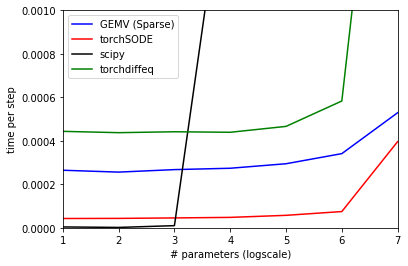

In [23]:
import math
psize = [10, 100, 1000, 10000, 100000, 1000000, 10000000]
psize = [math.log10(size) for size in psize]
plt.plot(psize, gemv_euler, color='blue')
plt.plot(psize, torchsode_euler, color='red')
plt.plot(psize, scipy.solve_ivp, color='black')
plt.plot(psize, torchdiffeq_euler, color='green')
plt.legend(['GEMV (Sparse)', 'torchSODE', 'scipy', 'torchdiffeq'])
axes = plt.gca()
axes.set_ylim([0, 0.001])
axes.set_xlim([1, max(psize)])
plt.xlabel('# parameters (logscale)')
plt.ylabel('time per step')
plt.show()

Text(0, 0.5, 'time per step (s)')

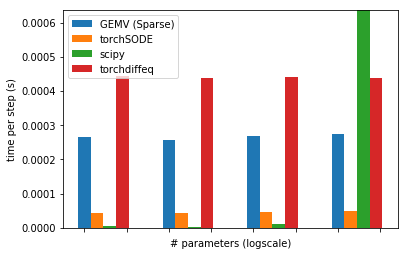

In [136]:
width = 0.15
y_pos = np.arange(4)
plt.bar(y_pos, gemv_euler[:4], width)
plt.bar(y_pos+width, torchsode_euler[:4], width)
plt.bar(y_pos+2*width, scipy.solve_ivp[:4], width)
plt.bar(y_pos+3*width, torchdiffeq_euler[:4], width)
plt.legend(['GEMV (Sparse)', 'torchSODE', 'scipy', 'torchdiffeq'])
plt.xlabel('# parameters (logscale)')
ax = plt.gca()
ax.set_xticklabels([])
ax.set_ylim([0, 0.35*max(scipy.solve_ivp[:4])])
plt.ylabel('time per step (s)')

Text(0, 0.5, 'time per step (s)')

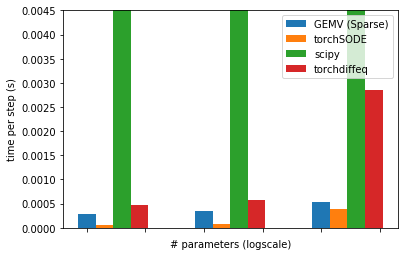

In [139]:
width = 0.15
y_pos = np.arange(4,7)
plt.bar(y_pos, gemv_euler[4:7], width)
plt.bar(y_pos+width, torchsode_euler[4:7], width)
plt.bar(y_pos+2*width, scipy.solve_ivp[4:7], width)
plt.bar(y_pos+3*width, torchdiffeq_euler[4:7], width)
plt.legend(['GEMV (Sparse)', 'torchSODE', 'scipy', 'torchdiffeq'])
plt.xlabel('# parameters (logscale)')
ax = plt.gca()
ax.set_xticklabels([])
ax.set_ylim([0, 0.45*max(scipy.solve_ivp[4:7])])
plt.ylabel('time per step (s)')

Text(0, 0.5, 'speedup')

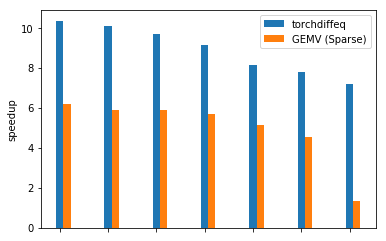

In [162]:
perf1 = torchdiffeq_euler/(torchsode_euler)
perf2 = gemv_euler/(torchsode_euler)
width = 0.15
y_pos = np.arange(7)
plt.bar(y_pos, perf1, width)
plt.bar(y_pos+width, perf2, width)
plt.legend(['torchdiffeq', 'GEMV (Sparse)'])
ax = plt.gca()
ax.set_xticklabels([])
plt.ylabel('speedup')